<a href="https://colab.research.google.com/github/shihongji/aml-exercise/blob/main/tomor_classifier_random_search_tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cd /content/
!unzip /content/sample_data/brain_tumor_dataset.zip > /dev/null
!pip install -q -U keras-tuner
!pip install -q -U autokeras

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
import keras_tuner
from keras_tuner import HyperModel
from keras_tuner.tuners import RandomSearch, Hyperband

In [ ]:
image_size = (224, 224)
image_shape = (image_size[0], image_size[1], 3)
batch = 32
data_dir = "/content/brain_tumor_dataset/"
epochs_to_train = 5
max_trials_for_search = 3

# data augmentation
train_data_gen = ImageDataGenerator(
    rescale=1./255, # normalization to 0-1
    zoom_range=0.2, # randomly zoom in or out by up to 20%
    horizontal_flip="True",
    vertical_flip="True",
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.1
)

test_data_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

# split/class generation
train_data = train_data_gen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch,
    class_mode="binary", # only have two classes
    subset="training"
)

test_data = test_data_gen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch,
    class_mode="binary",
    subset="validation"
)

print(train_data.class_indices)
print(test_data.class_indices)


Found 229 images belonging to 2 classes.
Found 24 images belonging to 2 classes.
{'no': 0, 'yes': 1}
{'no': 0, 'yes': 1}


Create initial mode

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 43264)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,768,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,825,345 (10.78 MB)

 Trainable params: 2,825,345 (10.78 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_data, epochs=epochs_to_train, verbose=1, validation_data=test_data)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 523ms/step - accuracy: 0.5415 - loss: 0.7116 - val_accuracy: 0.7083 - val_loss: 0.6318
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 403ms/step - accuracy: 0.4814 - loss: 0.6863 - val_accuracy: 0.6250 - val_loss: 0.6060
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 0.6154 - loss: 0.6922 - val_accuracy: 0.6250 - val_loss: 0.6117
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.6222 - loss: 0.6557 - val_accuracy: 0.6250 - val_loss: 0.5694
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 408ms/step - accuracy: 0.6276 - loss: 0.6359 - val_accuracy: 0.7083 - val_loss: 0.5486


In [ ]:
def plot_history(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    loss, acc = model.evaluate(test_data)
    print("Accuracy", acc)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.7083 - loss: 0.5486
Accuracy 0.7083333134651184


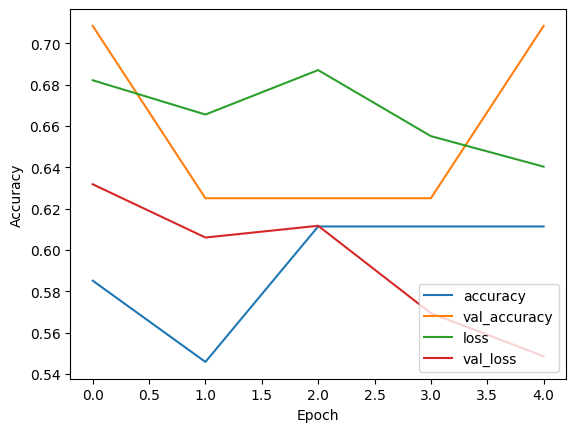

In [ ]:
plot_history(history)

In [ ]:
# second model
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=image_shape))
model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_2.add(layers.MaxPooling2D((2,2)))
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(128, activation='relu'))
model_2.add(layers.Dropout(0.2))
model_2.add(layers.Dense(1, activation='sigmoid'))

model_2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │       2,359,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,772,737 (10.58 MB)

 Trainable params: 2,772,737 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit(train_data, epochs=epochs_to_train, verbose=1, validation_data=test_data)

Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 488ms/step - accuracy: 0.5773 - loss: 0.7039 - val_accuracy: 0.6250 - val_loss: 0.6370
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step - accuracy: 0.6075 - loss: 0.6623 - val_accuracy: 0.6250 - val_loss: 0.5857
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - accuracy: 0.6388 - loss: 0.6240 - val_accuracy: 0.6250 - val_loss: 0.5559
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 523ms/step - accuracy: 0.5698 - loss: 0.6567 - val_accuracy: 0.6250 - val_loss: 0.5276
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 440ms/step - accuracy: 0.6091 - loss: 0.6162 - val_accuracy: 0.6250 - val_loss: 0.5380


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7083 - loss: 0.5486
Accuracy 0.7083333134651184


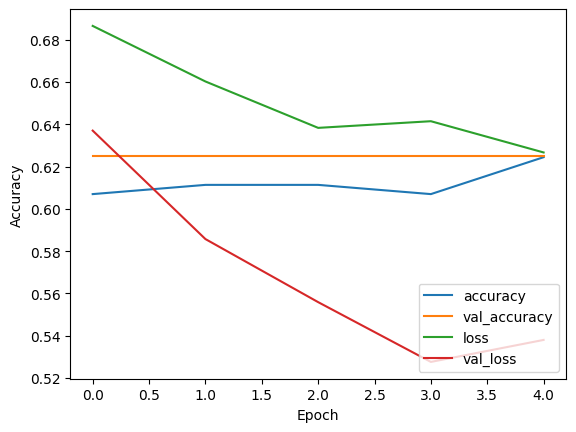

In [ ]:
plot_history(history_2)

In [ ]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Conv2D(hp.Choice('num_filters_1', values=[32, 64], default=32,),
                                kernel_size=3,
                                activation='relu',
                                input_shape=self.input_shape))
        model.add(layers.Conv2D(hp.Choice('num_filters_2', values=[64, 128], default=64,),
                                kernel_size=3,
                                activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=2))
        model.add(layers.Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(layers.Conv2D(hp.Choice('num_filters_3', values=[128, 256], default=128,),
                                kernel_size=3,
                                activation='relu'))
        model.add(layers.Conv2D(hp.Choice('num_filters_4', values=[128, 256], default=128,),
                                kernel_size=3,
                                activation='relu'))
        model.add(layers.MaxPooling2D(pool_size=2))
        model.add(layers.Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(layers.Flatten())
        model.add(layers.Dense(units=hp.Int('units', min_value=32, max_value=512, step=32, default=128),
                               activation=hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu')))
        model.add(layers.Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.05)))
        model.add(layers.Dense(self.num_classes, activation='sigmoid'))
        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model
hypermodel = CNNHyperModel(input_shape=image_shape, num_classes=1)


In [ ]:
random_search_tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=1234,
    max_trials=max_trials_for_search,
    executions_per_trial=1,
    directory='random_search',
    project_name='brain_tumor'
)

In [ ]:
random_search_tuner.search_space_summary()
random_search_tuner.search(train_data, epochs=epochs_to_train, validation_data=test_data)

Trial 3 Complete [00h 01m 27s]
val_accuracy: 0.625

Best val_accuracy So Far: 0.625
Total elapsed time: 00h 05m 43s


In [ ]:
random_search_tuner.results_summary()

random_search_best_model = random_search_tuner.get_best_models(num_models=1)[0]

random_search_best_model.summary()

loss, acc = random_search_best_model.evaluate(test_data)
print("Accuracy", acc)

Results summary
Results in random_search/brain_tumor
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
num_filters_1: 64
num_filters_2: 128
dropout_1: 0.25
num_filters_3: 128
num_filters_4: 128
dropout_2: 0.0
units: 352
dense_activation: tanh
dropout_3: 0.0
learning_rate: 0.002874055088465658
Score: 0.625

Trial 1 summary
Hyperparameters:
num_filters_1: 32
num_filters_2: 128
dropout_1: 0.05
num_filters_3: 256
num_filters_4: 256
dropout_2: 0.25
units: 96
dense_activation: sigmoid
dropout_3: 0.35000000000000003
learning_rate: 0.0029185317760266416
Score: 0.625

Trial 2 summary
Hyperparameters:
num_filters_1: 32
num_filters_2: 64
dropout_1: 0.25
num_filters_3: 256
num_filters_4: 128
dropout_2: 0.15000000000000002
units: 64
dense_activation: relu
dropout_3: 0.05
learning_rate: 0.00857683099445653
Score: 0.625


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 220, 220, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 110, 110, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 108, 108, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 106, 106, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 53, 53, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 359552)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 352)                 │     126,562,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 352)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             353 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,933,825 (484.21 MB)

 Trainable params: 126,933,825 (484.21 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step - accuracy: 0.6250 - loss: 1.5381
Accuracy 0.625


### Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Prediction is tumor. Confidence: 98.30


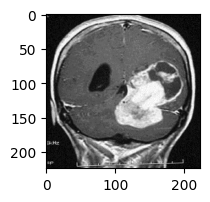

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Prediction is tumor. Confidence: 98.30


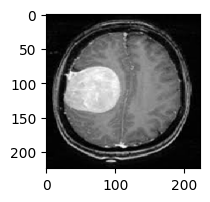

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Prediction is tumor. Confidence: 98.30


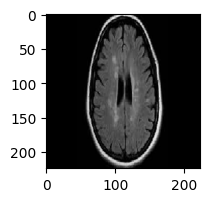

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
Prediction is tumor. Confidence: 98.30


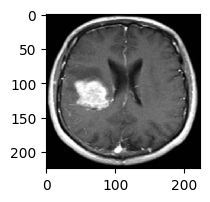

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
Prediction is tumor. Confidence: 98.30


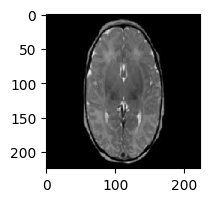

In [ ]:
import random
for i in range(0, 5):
    x, y = random.choice(test_data)
    image = x[i]
    pred = random_search_best_model.predict(x)

    if pred[i][0] < 0.5:
        format_float = "{:.2f}".format(100 - (pred[i][0]*100))
        print("Prediction is NO tumor. Confidence: " + format_float)
    else:
        format_float = "{:.2f}".format(pred[i][0]*100)
        print("Prediction is tumor. Confidence: " + format_float)

    plt.figure(figsize=(2,2))
    plt.imshow(image)
    plt.show()